### Taking the absolute difference of the images and highlighting the regions with difference with red color.

In [1]:
import cv2
import os

def highlight_difference(image1_path, image2_path, output_path):
    # Load images
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions.")

    # Compute pixel-wise absolute difference
    diff = cv2.absdiff(image1, image2)

    # Convert difference to grayscale
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Threshold to identify differing pixels
    _, threshold_diff = cv2.threshold(gray_diff, 50, 255, cv2.THRESH_BINARY)

    # Convert the differing pixels to red in the second image
    image2[threshold_diff != 0] = [0, 0, 255]  # Set differing pixels to red (BGR format)

    # Save the output image
    cv2.imwrite(output_path, image2)

def process_images_directory(input_directory, output_directory):
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Process each image pair in the input directory
    for subdir, _, files in os.walk(input_directory):
        for file in files:
            if file.endswith("_temp.jpg"):
                temp_image_path = os.path.join(subdir, file)
                test_image_path = os.path.join(subdir, file.replace("_temp.jpg", "_test.jpg"))

                # Ensure corresponding test image exists
                if os.path.exists(test_image_path):
                    output_path = os.path.join(output_directory, file.replace("_temp.jpg", ".jpg"))

                    # Highlight the pixel-wise difference and save the output image
                    highlight_difference(temp_image_path, test_image_path, output_path)

# Example usage
input_directory = r"E:\4th sem\Maths\project\pcb\DeepPCB-master\PCBData\group00041\00041"
output_directory = 'images'
process_images_directory(input_directory, output_directory)


### Sample visualization of above pre-processing

Template image


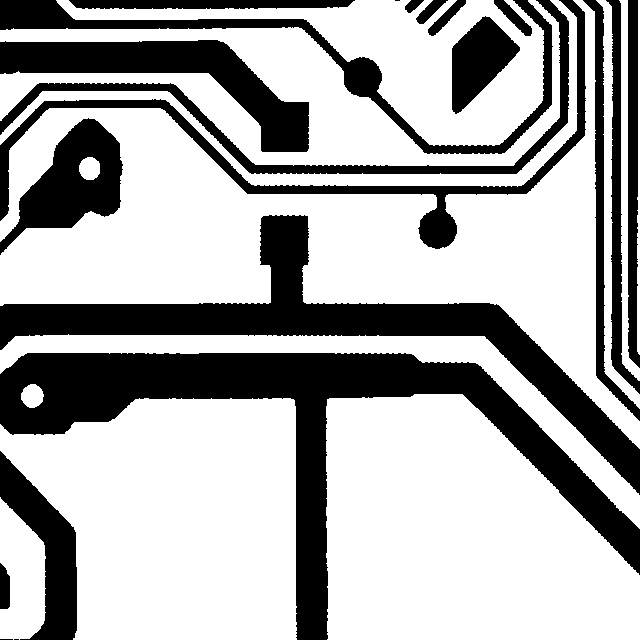

Defective image


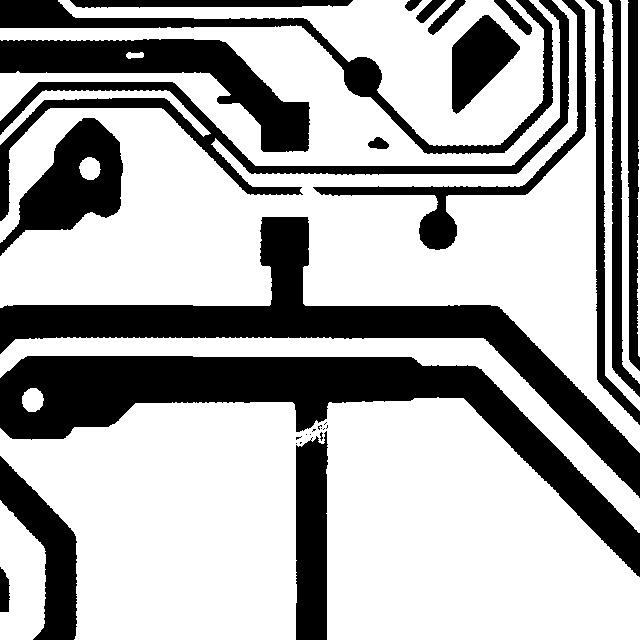

Preprocessed image


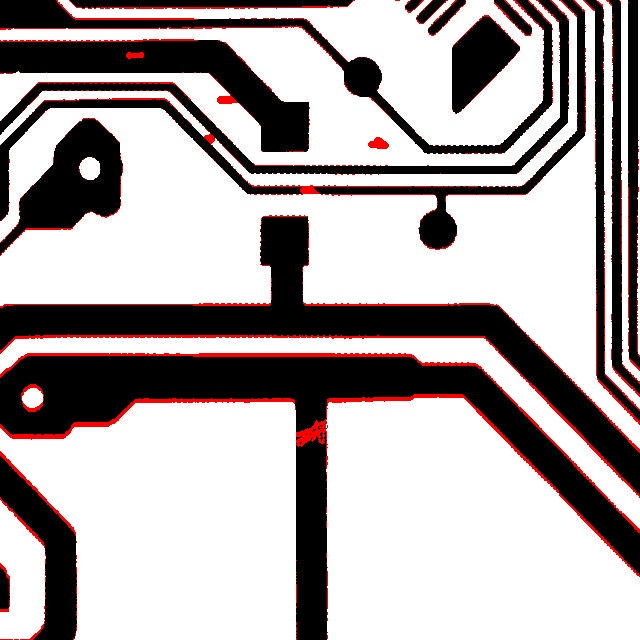

In [5]:
from PIL import Image
from IPython.display import display

# File paths to your images
image_paths = [r"00041\00041173_temp.jpg", r"00041\00041173_test.jpg", r"images\00041173.jpg"]
image_names=["Template image", "Defective image", "Preprocessed image"]
for i in range(3):
    print(image_names[i])
    display(Image.open(image_paths[i]))



### We planned to use YOLOv8 as our base classification model. So the dataset annotations are converted into YOLO annotation format

##### YOLO annotation format - label_id, x_center, y_center, width, height
##### Present annotation format - x1 y1 x2 y2 type

In [6]:
import os

def convert_annotation_to_yolo(annotation_path, yolo_path, image_width, image_height):
    with open(annotation_path, 'r') as annotation_file:
        lines = annotation_file.readlines()

    yolo_annotations = []
    for line in lines:
        # Parse annotation in the format: x1 y1 x2 y2 type
        values = line.strip().split()
        
        # Check if there are enough values to unpack
        if len(values) == 5:
            x1, y1, x2, y2, label_id = map(int, values[:])  # Exclude the last element as it's the type

            # Convert to YOLO format: label_id (x_center, y_center, width, height)
            x_center = (x1 + x2) / (2.0 * image_width)
            y_center = (y1 + y2) / (2.0 * image_height)
            width = (x2 - x1) / image_width
            height = (y2 - y1) / image_height

            yolo_annotations.append(f"{label_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    # Save YOLO format annotation
    yolo_annotation_path = os.path.join(yolo_path, os.path.basename(annotation_path).replace('.txt', '.txt'))
    with open(yolo_annotation_path, 'w') as yolo_file:
        yolo_file.writelines(yolo_annotations)

def process_annotations_directory(annotation_directory, yolo_output_directory, image_width, image_height):
    for subdir, _, files in os.walk(annotation_directory):
        for file in files:
            if file.endswith(".txt"):
                annotation_path = os.path.join(subdir, file)
                convert_annotation_to_yolo(annotation_path, yolo_output_directory, image_width, image_height)

# Example usage
annotation_directory = r"E:\4th sem\Maths\project\pcb\DeepPCB-master\PCBData\group00041\00041_not"
yolo_output_directory = 'labels'
image_width = 640  # Replace with the actual width of your images
image_height = 640  # Replace with the actual height of your images

process_annotations_directory(annotation_directory, yolo_output_directory, image_width, image_height)


### To train YOLOv8 on a pretrained setting there is directory specification on how to feed data to the model. The directory split has been taken here.

#### Train ratio - 70%
#### Validation ratio - 20%
#### Test ratio - 10%

In [7]:
import os
import random
import shutil

def split_data(images_dir, labels_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Get the list of filenames in both directories
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

    # Check if the two directories have the same files
    if set([os.path.splitext(f)[0] for f in image_files]) != set([os.path.splitext(f)[0] for f in label_files]):
        print("Error: Image and label directories do not have matching files.")
        return

    # Shuffle the list of filenames
    random.shuffle(image_files)

    # Calculate the number of files for each split
    total_files = len(image_files)
    train_size = int(total_files * train_ratio)
    val_size = int(total_files * val_ratio)
    test_size = total_files - train_size - val_size

    # Create directories for train, val, and test sets
    train_images_dir = 'train_images'
    train_labels_dir = 'train_labels'
    val_images_dir = 'val_images'
    val_labels_dir = 'val_labels'
    test_images_dir = 'test_images'
    test_labels_dir = 'test_labels'

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)

    # Split the files into train, val, and test sets
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]

    # Copy files to their respective directories
    for filename in train_files:
        shutil.copy(os.path.join(images_dir, filename), os.path.join(train_images_dir, filename))
        shutil.copy(os.path.join(labels_dir, os.path.splitext(filename)[0] + '.txt'), os.path.join(train_labels_dir, os.path.splitext(filename)[0] + '.txt'))

    for filename in val_files:
        shutil.copy(os.path.join(images_dir, filename), os.path.join(val_images_dir, filename))
        shutil.copy(os.path.join(labels_dir, os.path.splitext(filename)[0] + '.txt'), os.path.join(val_labels_dir, os.path.splitext(filename)[0] + '.txt'))

    for filename in test_files:
        shutil.copy(os.path.join(images_dir, filename), os.path.join(test_images_dir, filename))
        shutil.copy(os.path.join(labels_dir, os.path.splitext(filename)[0] + '.txt'), os.path.join(test_labels_dir, os.path.splitext(filename)[0] + '.txt'))

    print("Data split completed.")

# Replace 'path_to_images' and 'path_to_labels' with your actual paths
split_data('images', 'labels')


Data split completed.
